In [244]:
import os
import pandas as pd
import datetime

In [350]:
csv_list = []
appended = pd.DataFrame()
LUIGI_LOG_PATH='/usr/local/trustyou/home/andream/nfs/processmining/experiments'
#LUIGI_LOG_PATH = '/usr/local/trustyou/home/andream/nfs/processmining/minilogs/daily/'
#LUIGI_LOG_PATH = '/usr/local/trustyou/home/andream/nfs/processmining/minilogs/table-precomp/logs/tch/'
for filename in os.listdir(LUIGI_LOG_PATH):
    #if filename.endswith('.csv') and filename.startswith('catts_1trace_7act_12hDur_running-example.csv'):
    #if filename.endswith('.csv') and filename.startswith('catts_1trace_7act_0dur_running-example.csv'):
    #if filename.endswith('.csv') and filename.startswith('catts_1trace_7act_1dayDur_meets_running-example.csv'):
    #if filename.endswith('.csv') and filename.startswith('catts_1trace_7act_meetsStarts'):
    #if filename.endswith('.csv') and filename.startswith('catts_daily.2019-09-.csv'):
        log_path = LUIGI_LOG_PATH+'/'+filename
        csv_list.append(filename)
        print('Preprocessing... ',log_path)
        df = pd.read_csv(log_path, index_col=False)
        appended = appended.append(df)

#appended_df
csv_list.sort()
print(csv_list)

filename = os.path.splitext(csv_list[0])[0]

#appended_df.to_datetime(start_time, format="%Y-%m-%d:%H:%M:%S").sort_values()
appended['start_time'] = pd.to_datetime(appended['start_time'], format="%Y-%m-%d %H:%M:%S").sort_values()
appended['end_time'] = pd.to_datetime(appended['end_time'], format="%Y-%m-%d %H:%M:%S").sort_values()
appended = appended.sort_values(by=['start_time'], ascending=True)
appended['case'] = appended.apply(lambda row: str(row['case']), axis=1)
appended

Preprocessing...  /usr/local/trustyou/home/andream/nfs/processmining/experiments/catts_1trace_7act_12hDur_running-example.csv
['catts_1trace_7act_12hDur_running-example.csv']


,case,activity,start_time,end_time
0,3,register request,2011-01-09 11:02:00,2011-01-09 23:02:00
1,3,examine casually,2011-01-10 11:02:00,2011-01-10 23:02:00
2,3,check ticket,2011-01-11 11:02:00,2011-01-11 23:02:00
3,3,decide,2011-01-12 11:02:00,2011-01-12 23:02:00
4,3,reinitiate request,2011-01-13 11:02:00,2011-01-13 23:02:00
5,3,examine thoroughly,2011-01-14 11:02:00,2011-01-14 23:02:00
6,3,check ticket,2011-01-15 11:02:00,2011-01-15 23:02:00
7,3,decide,2011-01-16 11:02:00,2011-01-16 23:02:00
8,3,pay compensation,2011-01-17 11:02:00,2011-01-17 23:02:00


In [351]:
def get_zero_points(group):
    group['zero_point'] = group['start_time'].min()
    return group

In [352]:
print(appended['start_time'].min(), appended['end_time'].max())
grouped = appended.groupby(['case'])
grouped = grouped.apply(get_zero_points)
grouped.head()

2011-01-09 11:02:00 2011-01-17 23:02:00


,case,activity,start_time,end_time,zero_point
0,3,register request,2011-01-09 11:02:00,2011-01-09 23:02:00,2011-01-09 11:02:00
1,3,examine casually,2011-01-10 11:02:00,2011-01-10 23:02:00,2011-01-09 11:02:00
2,3,check ticket,2011-01-11 11:02:00,2011-01-11 23:02:00,2011-01-09 11:02:00
3,3,decide,2011-01-12 11:02:00,2011-01-12 23:02:00,2011-01-09 11:02:00
4,3,reinitiate request,2011-01-13 11:02:00,2011-01-13 23:02:00,2011-01-09 11:02:00


In [353]:
def get_duration(start_time, end_time):
    start = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    end = datetime.datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')
    duration = abs(end - start)
    return duration
#get_duration(ex['timestamp'][10],ex['timestamp'][1])

In [354]:
#zero_points = appended[appended['activity']=='AllTasks']
#zero_points['zero_point'] = zero_points['start_time']
#zero_points = zero_points.drop(['activity', 'start_time', 'end_time'], axis=1)
#zero_points.head()

In [355]:
#tt = pd.merge(start_df, end_df, on=['task_call', 'source_file'], how='outer')

appended = pd.merge(grouped, appended, on = ['case', 'activity', 'start_time', 'end_time'], how = 'inner') 
print(len(appended))
appended.head()

9


,case,activity,start_time,end_time,zero_point
0,3,register request,2011-01-09 11:02:00,2011-01-09 23:02:00,2011-01-09 11:02:00
1,3,examine casually,2011-01-10 11:02:00,2011-01-10 23:02:00,2011-01-09 11:02:00
2,3,check ticket,2011-01-11 11:02:00,2011-01-11 23:02:00,2011-01-09 11:02:00
3,3,decide,2011-01-12 11:02:00,2011-01-12 23:02:00,2011-01-09 11:02:00
4,3,reinitiate request,2011-01-13 11:02:00,2011-01-13 23:02:00,2011-01-09 11:02:00


In [356]:
#excluding = ['AllTasks', 'CrawlTask', 'ExtractTask']
excluding = ['AllTasks']
exclusive = appended.copy()
exclusive['rel_start'] = exclusive.apply(lambda row: 
                                       str(get_duration(str(row['zero_point']),
                                                        str(row['start_time']))), axis=1)
exclusive['rel_end'] = exclusive.apply(lambda row: 
                                       str(get_duration(str(row['zero_point']),
                                                        str(row['end_time']))), axis=1)
#list(pd.to_timedelta(x, errors="coerce").dt.total_seconds())

exclusive['num_start']= list(pd.to_timedelta(exclusive['rel_start'], errors="coerce").dt.total_seconds ())
exclusive['num_end']= list(pd.to_timedelta(exclusive['rel_end'], errors="coerce").dt.total_seconds ())

#appended.apply(lambda row: row['rel_start'], axis=1)
#appended['num_end']= appended.apply(lambda row: (row['rel_end'].total_seconds())/60/60, axis=1)

exclusive = exclusive[['case', 'activity','rel_start', 'rel_end', 'num_start', 'num_end', 'start_time', 'end_time']]

exclusive = exclusive.sort_values(by=['num_start'], ascending=True)
exclusive = exclusive[~exclusive['activity'].isin(excluding)].reset_index()
#exclusive = exclusive.head(100)
print(len(exclusive))
exclusive

9


,index,case,activity,rel_start,rel_end,num_start,num_end,start_time,end_time
0,0,3,register request,0:00:00,12:00:00,0.0,43200.0,2011-01-09 11:02:00,2011-01-09 23:02:00
1,1,3,examine casually,"1 day, 0:00:00","1 day, 12:00:00",86400.0,129600.0,2011-01-10 11:02:00,2011-01-10 23:02:00
2,2,3,check ticket,"2 days, 0:00:00","2 days, 12:00:00",172800.0,216000.0,2011-01-11 11:02:00,2011-01-11 23:02:00
3,3,3,decide,"3 days, 0:00:00","3 days, 12:00:00",259200.0,302400.0,2011-01-12 11:02:00,2011-01-12 23:02:00
4,4,3,reinitiate request,"4 days, 0:00:00","4 days, 12:00:00",345600.0,388800.0,2011-01-13 11:02:00,2011-01-13 23:02:00
5,5,3,examine thoroughly,"5 days, 0:00:00","5 days, 12:00:00",432000.0,475200.0,2011-01-14 11:02:00,2011-01-14 23:02:00
6,6,3,check ticket,"6 days, 0:00:00","6 days, 12:00:00",518400.0,561600.0,2011-01-15 11:02:00,2011-01-15 23:02:00
7,7,3,decide,"7 days, 0:00:00","7 days, 12:00:00",604800.0,648000.0,2011-01-16 11:02:00,2011-01-16 23:02:00
8,8,3,pay compensation,"8 days, 0:00:00","8 days, 12:00:00",691200.0,734400.0,2011-01-17 11:02:00,2011-01-17 23:02:00


# Point Transformer: Start time - End time

In [357]:
snippet = exclusive[['case','activity','rel_start','rel_end','num_start','num_end']].iloc[: , :]
#snippet = exclusive.iloc[199:500 , :].reset_index()
snippet = snippet.sort_values(by=['case','num_start'], ascending=True)
print(len(snippet))

9


In [358]:
counts = snippet.groupby(['activity']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
counts = counts.sort_values(by=['counts'], ascending = False)
counts.head()

#appended = appended.head(100)
#len(appended)
unique_act = snippet['activity'].unique().tolist()
print(len(unique_act), ' activities')

unique_trace = snippet['case'].unique().tolist()
print(len(unique_trace), ' cases')


7  activities
1  cases


In [359]:
def get_time_list_from_seconds(list):
    result = []
    for item in list:
        if item < 0: 
            result.append('')
        else: 
            result.append(datetime.timedelta(seconds=item))
    return result


In [360]:
import time

def avg_datetime(series):
    averages = (series.sum())/len(series)
    #averages = time.strftime('%H:%M:%S', time.gmtime(averages))
    return averages

def get_average_times(group):
    group['average_start'] = time.strftime('%H:%M:%S', time.gmtime(avg_datetime(group['num_start'])))
    group['average_end'] = time.strftime('%H:%M:%S', time.gmtime(avg_datetime(group['num_end'])))
    group['num_start'] = avg_datetime(group['num_start'])
    group['num_end'] = avg_datetime(group['num_end'])
    return group

def get_data_selection_avgtrace(df):
    average_trace = df[['case','activity','rel_start','rel_end','num_start','num_end']].iloc[: , :]
    average_trace = average_trace.groupby(['activity'])
    average_trace = average_trace.apply(get_average_times)
    average_trace = average_trace.drop_duplicates('activity', keep='first').reset_index()
    average_trace['case'] = 'Average Case'
    average_trace = average_trace[['activity','average_start', 'average_end','num_start','num_end', 'case']].sort_values(by=['num_start'])
    return average_trace

In [361]:
def get_skyline_points(df):
    #skyline = pd.DataFrame(columns=['x','y'])
    df.sort_values(by=['num_start'])
    max_x = []
    max_y = []
    for i, e in enumerate(df['num_start']):
        maxi = max(df['num_start'][0:i+1].values.tolist())
        mayi = max(df['num_end'][0:i+1].values.tolist())
        if maxi in df[df['num_end']==mayi]['num_start'].values:
            max_x.append(maxi)
            max_y.append(mayi)

    skyline = pd.DataFrame({'num_start':max_x, 'num_end':max_y})
    skyline = skyline.drop_duplicates().reset_index()[['num_start','num_end']]

    return skyline

#first_case = snippet.loc[snippet['case']==snippet['case'][0]].reset_index()
#get_skyline_points(first_case).head()

In [375]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import sys

def get_color_from_label(label, color):
    return color

def newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax], color='grey', linestyle='--', linewidth=1)
    ax.add_line(l)
    return l

def draw_traces(data_selection, ax, draw_skylines=None):
    colormapt = cm.gist_ncar
    trace_colorlist = [colors.rgb2hex(colormapt(i)) for i in np.linspace(0, 0.9, len(unique_trace))]
    trace_legend = dict(zip(unique_trace, trace_colorlist))
    for j, k in enumerate(data_selection['case'].drop_duplicates()):
        current = data_selection[data_selection['case']==k]
        skyline = get_skyline_points(current)
        l = k
        c = trace_legend.get(l)

        if draw_skylines: 
            ax.plot(skyline['num_start'], skyline['num_end'], label='skyline '+k, zorder=0, color=c)
        else: 
            ax.plot(current['num_start'], current['num_end'], label='trace '+k, zorder=0, color=c)
            
def draw_allen_lines(allen_point, ax, yax, duration_plot=None):
            x = allen_point['num_start'].values[0]
            y = allen_point['num_end'].values[0]

            if duration_plot: 
                ax.axvline(x, c='grey', linewidth=1, linestyle='--')
                ax.axvline(x+y, c='grey', linewidth=1, linestyle='--')
                newline([x,y],[x+2*y,-y])
                newline([x-y,y],[x+y,-y])
            else:
                ax.plot([x,x],[x,yax],'k-', c='grey', linewidth=1, linestyle='--')
                ax.plot([y,y],[y,yax],'k-', c='grey', linewidth=1, linestyle='--')
                ax.plot([0,x],[x,x],'k-', c='grey', linewidth=1, linestyle='--')
                ax.plot([0,y],[y,y],'k-', c='grey', linewidth=1, linestyle='--')
                
def plot_point_transformer(title, data_selection, activity=None, traces=None,  allen_point=None, size=None, duration_plot=None, draw_skylines=None):
    fig, ax = plt.subplots()
    
    if size: 
        fig.set_size_inches(18.5, 18.5)

    #colormap = cm.nipy_spectral
    #colormap = cm.gist_ncar
    #colormap = cm.prism
    #colormap = cm.tab20
    colormap = cm.hsv
    colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(unique_act))]
    legend = dict(zip(unique_act, colorlist))
    colorby = 'activity'
    
    if activity:
        data_selection = data_selection.loc[data_selection['activity']==activity].reset_index()
        colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(unique_trace))]
        legend = dict(zip(unique_trace, colorlist))
        colorby = 'case'
    elif traces:
        data_selection = data_selection.loc[data_selection['case'].isin(traces)].reset_index()
    
    for i, e in enumerate(data_selection['num_start']):
        x = data_selection['num_start'][i]
        y = data_selection['num_end'][i]
        l = data_selection[colorby][i]
        c = legend.get(l)

        ax.scatter(x, y, label=l, s=50, linewidth=0.1, c=c)
    
    yin, yax= ax.get_ylim()
    xin, xax= ax.get_xlim()
    ax.set_xlim(xmin=0)
    ax.set_ylim(ymin=0)
    
    if not duration_plot: 
        #Draw diagonal
        newline([0,0],[max(xax,yax),max(xax,yax)])
        ax.set_ylabel('End time [mins]')
    else: 
        ax.set_ylabel('Duration [seconds]')

    if traces:
        draw_traces(data_selection, ax, draw_skylines=draw_skylines)
            
    if not allen_point is None :# Weird if statement because of maybe empty object or dataframe
        draw_allen_lines(allen_point, ax, yax, duration_plot=duration_plot)    
    
    ax.legend()
    ax.set_xlabel('Start time [mins]')

    xlocs, labels = plt.xticks()
    ylocs, labels = plt.yticks()
    plt.xticks(xlocs[1:], get_time_list_from_seconds(xlocs[1:]),rotation='vertical')
    plt.yticks(ylocs[1:], get_time_list_from_seconds(ylocs[1:])) 

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    plt.legend(by_label.values(), by_label.keys())
    plt.title(title)
    plt.show()
    return fig
#plot_point_transformer('Point transformer: Activity \''+ str(snippet['activity'][6]) + '\' only', snippet , activity='reject request')
#plot_point_transformer('Point transformer: All activities in all traces', snippet)
#plot_point_transformer('Point transformer: Trace \''+ str(snippet['case'][0]) + '\' only', snippet)
#plot_point_transformer('Point transformer: Average trace from all activities', snippet)

In [377]:
row = snippet.iloc[ 0 , : ].to_frame().transpose()
#row = snippet[(snippet['case']==1)&(snippet['num_start']==536760)]
print(row)
ymin=((row['num_end'].values[0]
      -row['num_start'].values[0]))
print(ymin)

print('Num. end ', row['num_end'].values[0])
print('Num. start ', row['num_start'].values[0])

  case          activity rel_start   rel_end num_start num_end
0    3  register request   0:00:00  12:00:00         0   43200
43200.0
Num. end  43200.0
Num. start  0.0


## Point transformer: One trace only

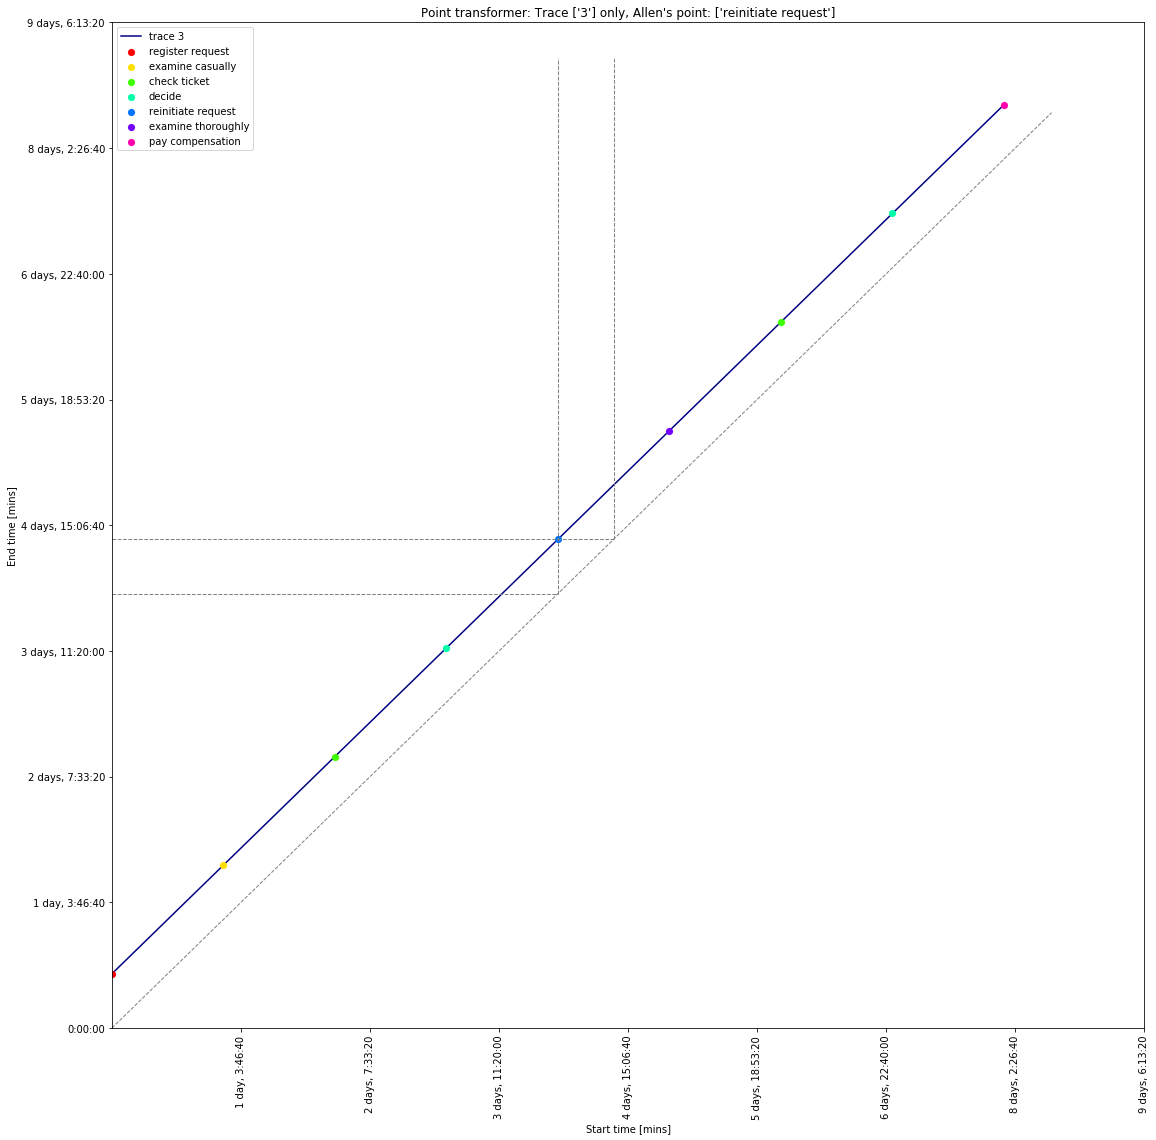

/usr/local/trustyou/home/andream/nfs/processmining/experiments
Saving in  /usr/local/trustyou/home/andream/nfs/processmining/experiments/catts_1trace_7act_12hDur_running-example_point_transformer_selectedTraces.png


In [378]:
#plot_point_transformer('Point transformer: Trace \''+ str(snippet['case'][0]) + '\' only', snippet)
#traces_selection = unique_trace[2:3]
traces_selection = [unique_trace[0]]
data_selection = snippet.loc[snippet['case'].isin(traces_selection)].reset_index().iloc[:]
point = data_selection.iloc[ 4 , : ].to_frame().transpose()
figurept = plot_point_transformer('Point transformer: Trace '+ str(traces_selection) + ' only, Allen\'s point: '+str(point['activity'].values), data_selection, size=1, traces=traces_selection, allen_point=point)

print(LUIGI_LOG_PATH)

OUTPUT_PATH = LUIGI_LOG_PATH+'/'+filename+'_point_transformer_selectedTraces'+'.png'
print('Saving in ',OUTPUT_PATH)
figurept.savefig(OUTPUT_PATH)

## Point Transformer: All activities in all traces

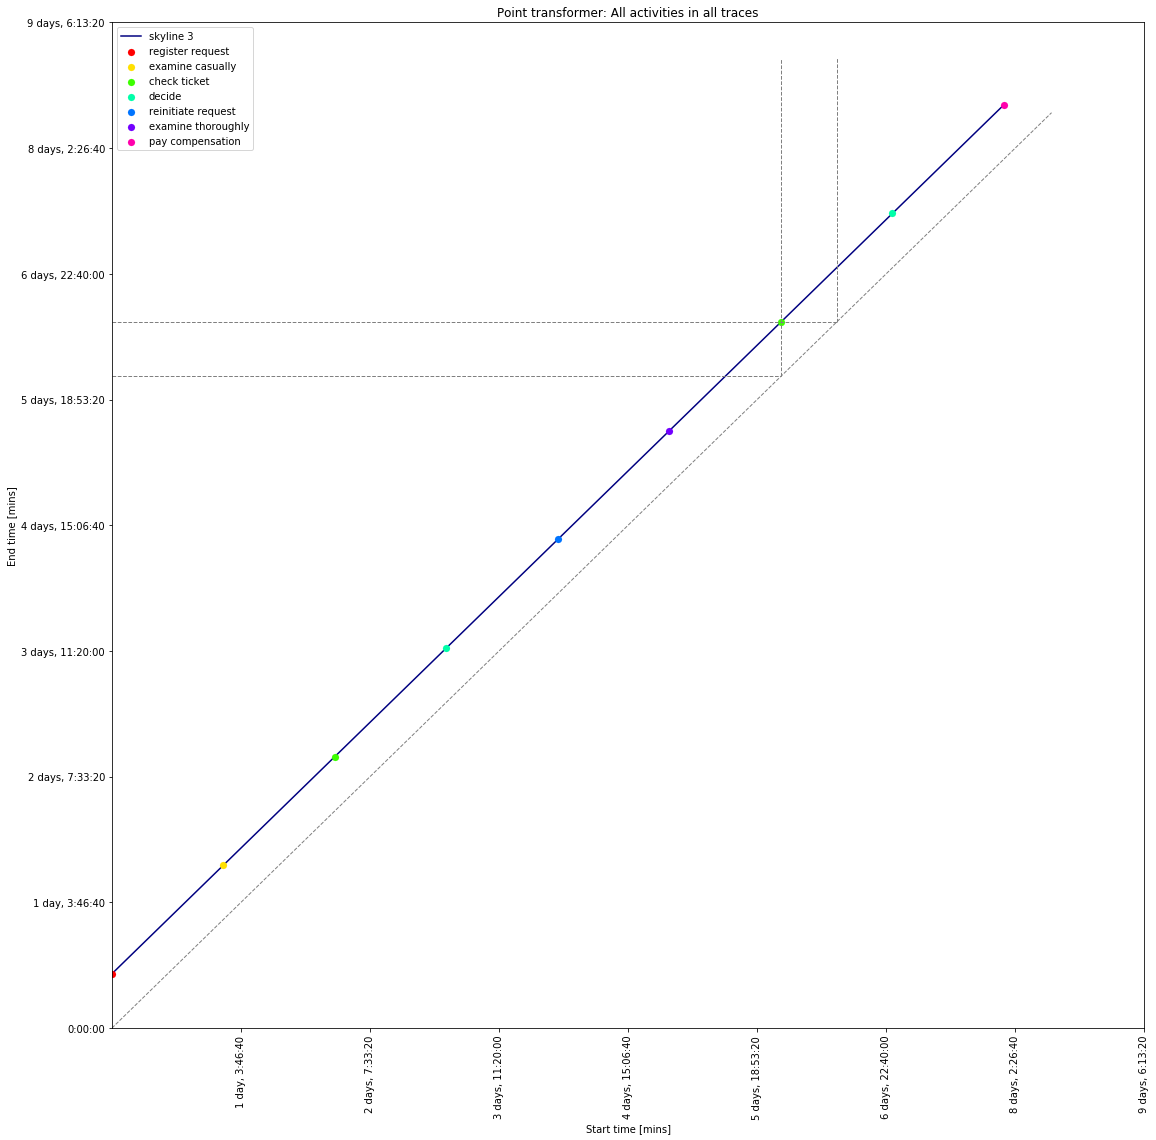

In [379]:
traces_selection = snippet['case'].drop_duplicates().tolist()
#print(point)
point = snippet.iloc[ 6 , : ].to_frame().transpose()
figurepl = plot_point_transformer('Point transformer: All activities in all traces', snippet, allen_point=point, traces=traces_selection,  size=1, draw_skylines=1)
#plot_point_transformer('Point transformer: All activities in all traces', snippet, size=1, allen_point=snippet[(snippet['case']==4)&(snippet['num_start']==75840)])

## Point transformer: Average trace from all activities

['register request', 'examine casually', 'check ticket', 'decide', 'reinitiate request', 'examine thoroughly', 'pay compensation']


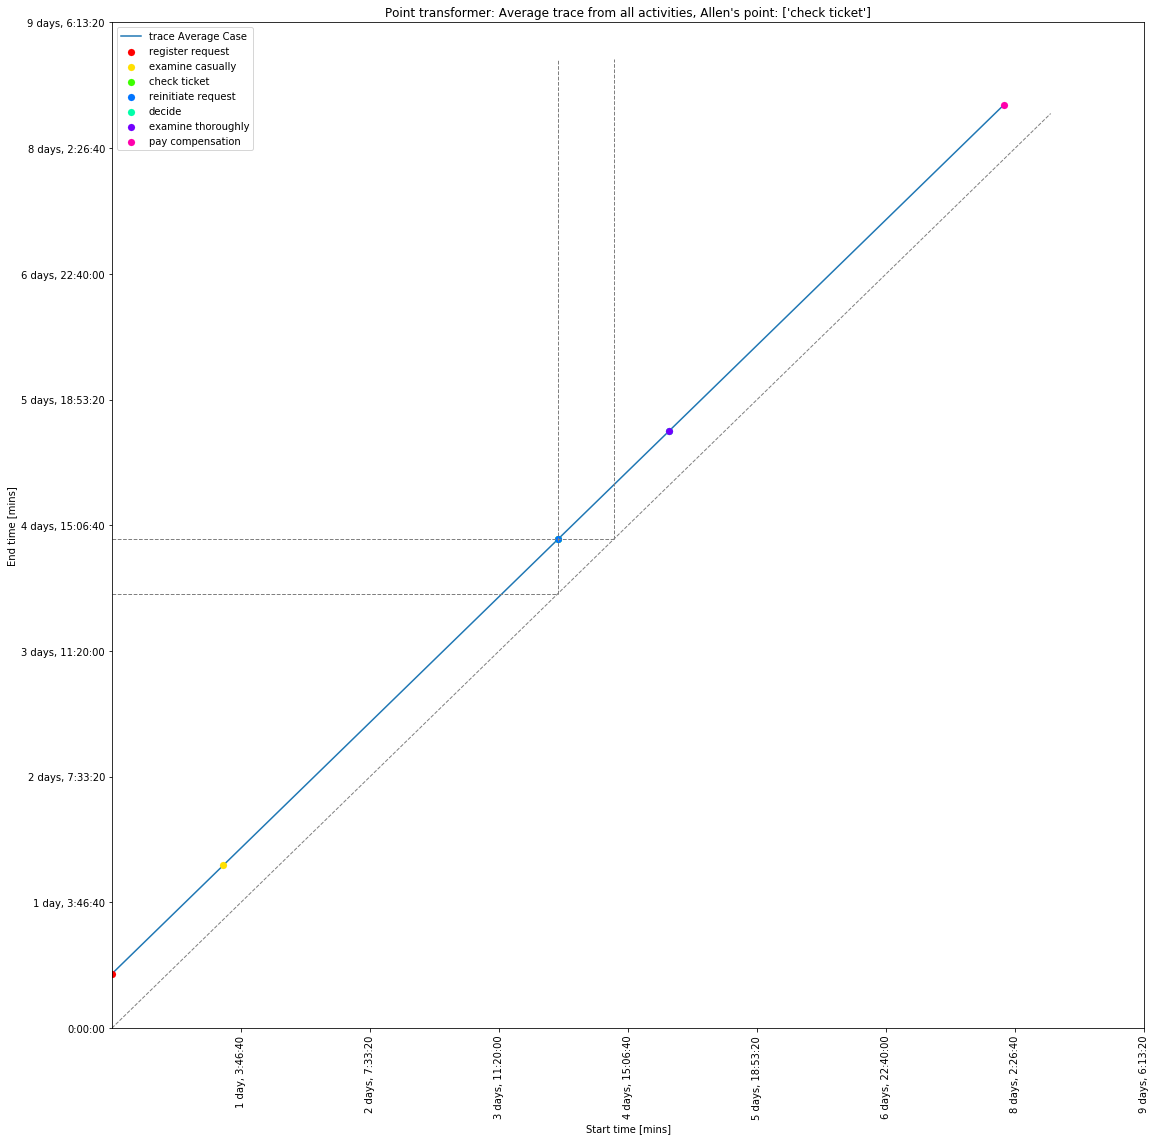

Saving in  /usr/local/trustyou/home/andream/nfs/processmining/experiments/catts_1trace_7act_12hDur_running-example_point_transformer_averageTrace.png


In [380]:
#FIXME: Average End and start are only taking hours:minutes and not days into account
print(snippet['activity'].drop_duplicates().tolist())
data_selection = get_data_selection_avgtrace(snippet).iloc[:]
traces_selection = data_selection['case'].drop_duplicates().tolist()
point = data_selection.iloc[ 2 , : ].to_frame().transpose()
#print(data_selection)
plot_point_transformer('Point transformer: Average trace from all activities, Allen\'s point: '+str(point['activity'].values), data_selection, traces=traces_selection, size=1, allen_point=point)
#plot_point_transformer('Point transformer: Average trace from all activities', snippet, allen_point=point)

OUTPUT_PATH = LUIGI_LOG_PATH+'/'+filename+'_point_transformer_averageTrace'+'.png'
print('Saving in ',OUTPUT_PATH)
figurept.savefig(OUTPUT_PATH)

## Point transformer: One Activity only

There are  7 unique activities.
examine casually


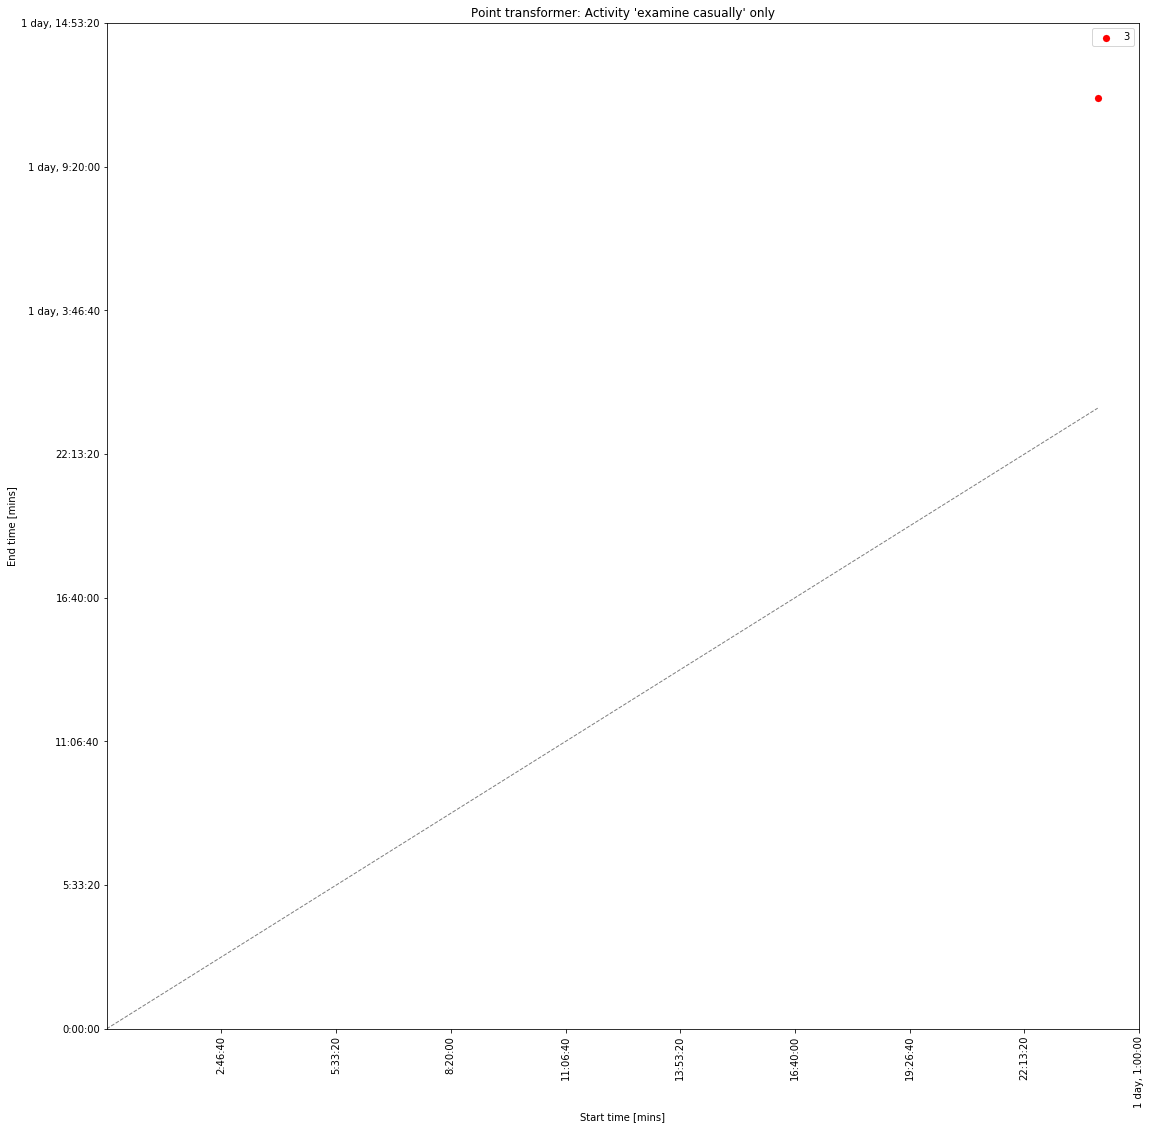

In [381]:
#TODO: Adapt frame dynamically
#TODO: Add start by zero option
print('There are ', len(unique_act), 'unique activities.')
activity_selection=unique_act[1]
print(activity_selection)
figurepl = plot_point_transformer('Point transformer: Activity \''+ str(activity_selection) + '\' only', snippet , activity=activity_selection, size=1)

In [382]:
#TODO: Test consistency of "duration and start time" plot
#TODO: Clean real data from daily to parameterwise activities
#TODO: Pseudonimize data for uni
#TODO: Drifts?




# Point Transformer: Start time - Duration

In [383]:
snippet['rel_end'].head()[0]

'12:00:00'

In [384]:
def get_duration(start_time, end_time):
    start = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    end = datetime.datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')
    duration = abs(end - start)
    return duration
#get_duration(ex['timestamp'][10],ex['timestamp'][1])

In [385]:
w_duration = exclusive.copy()
w_duration['duration'] = w_duration.apply(lambda row: str(get_duration(str(row['start_time']),str(row['end_time']))), axis=1)
w_duration['t_duration']= w_duration.apply(lambda row: (get_duration(str(row['start_time']),str(row['end_time'])).total_seconds()), axis=1)
print(len(w_duration))
print(w_duration[['case','activity','rel_start','rel_end']])

w_duration = w_duration[['case','activity','rel_start','num_start', 'duration', 't_duration']]
w_duration['rel_end']=w_duration['duration']
w_duration['num_end']=w_duration['t_duration']


w_duration.head()

9
  case            activity        rel_start           rel_end
0    3    register request          0:00:00          12:00:00
1    3    examine casually   1 day, 0:00:00   1 day, 12:00:00
2    3        check ticket  2 days, 0:00:00  2 days, 12:00:00
3    3              decide  3 days, 0:00:00  3 days, 12:00:00
4    3  reinitiate request  4 days, 0:00:00  4 days, 12:00:00
5    3  examine thoroughly  5 days, 0:00:00  5 days, 12:00:00
6    3        check ticket  6 days, 0:00:00  6 days, 12:00:00
7    3              decide  7 days, 0:00:00  7 days, 12:00:00
8    3    pay compensation  8 days, 0:00:00  8 days, 12:00:00


,case,activity,rel_start,num_start,duration,t_duration,rel_end,num_end
0,3,register request,0:00:00,0.0,12:00:00,43200.0,12:00:00,43200.0
1,3,examine casually,"1 day, 0:00:00",86400.0,12:00:00,43200.0,12:00:00,43200.0
2,3,check ticket,"2 days, 0:00:00",172800.0,12:00:00,43200.0,12:00:00,43200.0
3,3,decide,"3 days, 0:00:00",259200.0,12:00:00,43200.0,12:00:00,43200.0
4,3,reinitiate request,"4 days, 0:00:00",345600.0,12:00:00,43200.0,12:00:00,43200.0


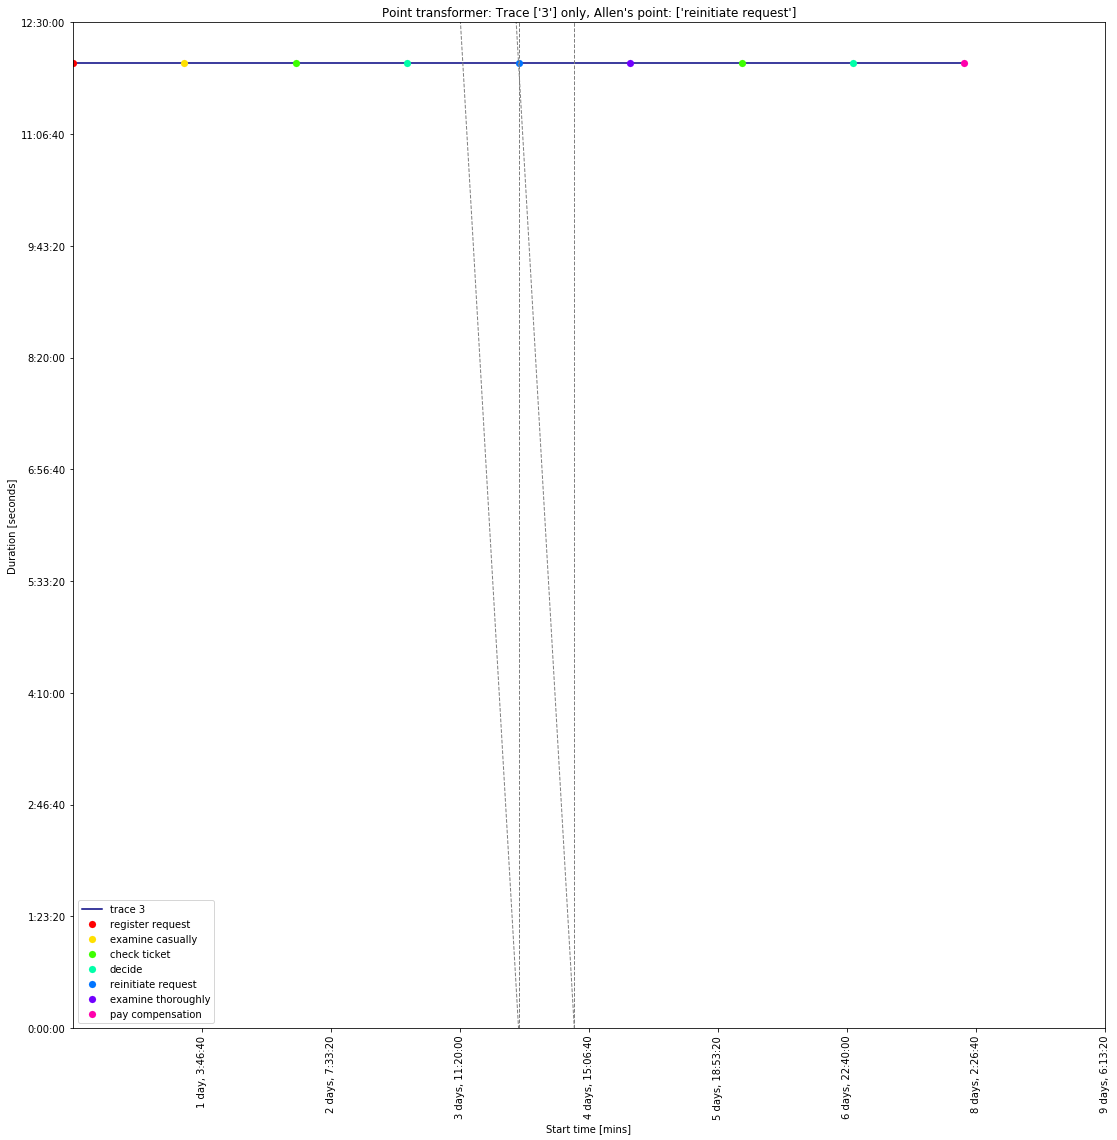

Saving in  /usr/local/trustyou/home/andream/nfs/processmining/experiments/catts_1trace_7act_12hDur_running-example_point_transformer_duration_selectedTraces.png


In [386]:
#TODO: Suspect 'meets' line is wrong
point = w_duration.iloc[ 4 , : ].to_frame().transpose()
traces_selection = w_duration['case'].drop_duplicates().tolist()
#print(point)
figurept = plot_point_transformer('Point transformer: Trace '+ str(traces_selection) + ' only, Allen\'s point: '+str(point['activity'].values), w_duration, duration_plot=1, allen_point=point, traces=traces_selection, size=1)
#plot_point_transformer('Point transformer: All activities in all traces', snippet, size=1, allen_point=snippet[(snippet['case']==4)&(snippet['num_start']==75840)])

OUTPUT_PATH = LUIGI_LOG_PATH+'/'+filename+'_point_transformer_duration_selectedTraces'+'.png'
print('Saving in ',OUTPUT_PATH)
figurept.savefig(OUTPUT_PATH)

  case            activity          start_time            end_time
0    3    register request 2011-01-09 11:02:00 2011-01-09 23:02:00
1    3    examine casually 2011-01-10 11:02:00 2011-01-10 23:02:00
2    3        check ticket 2011-01-11 11:02:00 2011-01-11 23:02:00
3    3              decide 2011-01-12 11:02:00 2011-01-12 23:02:00
4    3  reinitiate request 2011-01-13 11:02:00 2011-01-13 23:02:00
5    3  examine thoroughly 2011-01-14 11:02:00 2011-01-14 23:02:00
6    3        check ticket 2011-01-15 11:02:00 2011-01-15 23:02:00
7    3              decide 2011-01-16 11:02:00 2011-01-16 23:02:00
8    3    pay compensation 2011-01-17 11:02:00 2011-01-17 23:02:00


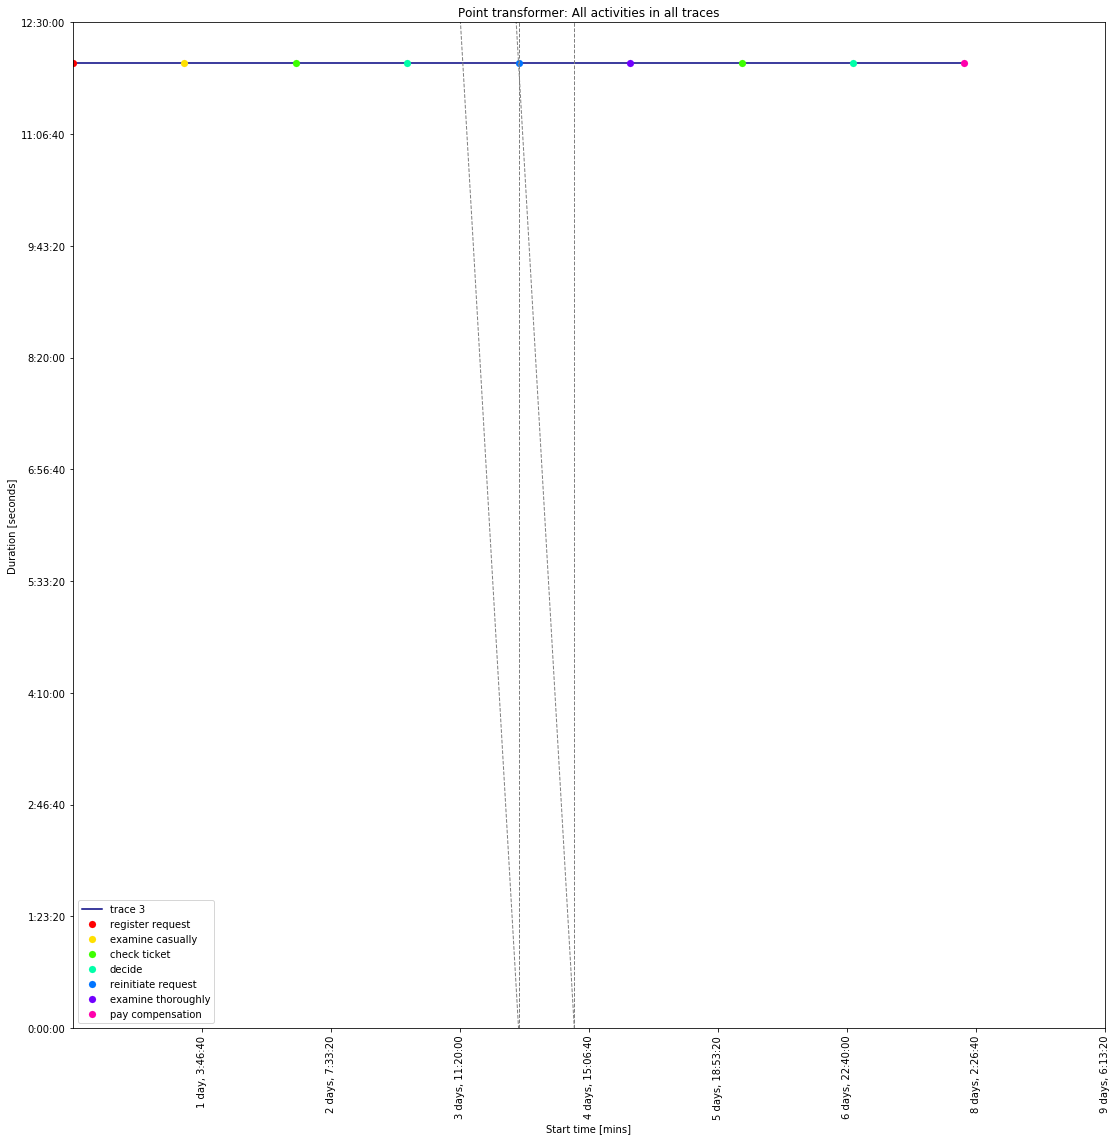

In [387]:
point = w_duration.iloc[ 4 , : ].to_frame().transpose()
print(appended[['case','activity','start_time','end_time']].sort_values(by=['case']))
figurepl = plot_point_transformer('Point transformer: All activities in all traces', w_duration, size=1, duration_plot=1, allen_point=point, traces=traces_selection)
#plot_point_transformer('Point transformer: All activities in all traces', snippet, size=1, allen_point=snippet[(snippet['case']==4)&(snippet['num_start']==75840)])

## Experiments

Experiment logs conain variations of: 
- Time
- Structure
- Allen relationships between activities

| # Traces | # Unique activities | Filename | Time variation | Structure variation | Allen variation  | Further description | Expectations | Observations | Further ideas |
|----------|---------------------|----------|----------------|---------------------|------------------|---------------------|--------------|--------------|---------------|
|       1  |          7          | catts_1trace_7act_0dur_running-example.csv | Constant 0 sec duration | None | "after/before" relations only  |          |  ||
|       1  |          7          | catts_1trace_7act_12hDur_running-example.csv | Constant duration | None | "after/before" relations only  |          |  ||
|       1  |          7          | catts_1trace_7act_1dayDur_meets_running-example.csv | Constant duration | None | Contains "starts", "meets" & "finishes" relations |          |  |
|       1  |          7          | catts_1trace_7act_meetsStartedByFinishedBy_running-example.csv | Constant duration | None | Contains "started by", "meets" & "finished by" relations |          |  |
|       1  |          7          | catts_1trace_7act_meetsOverlapsOverlappedBy_running-example.csv | Constant duration | None | Contains "overlaps", "meets" & "overlapped by" relations |          |  |  
|       1  |          8          |  | Variable duration bt. activities | None | "after/before" relations only  |          |  |          
|       2  |          8          |  | Constant deviation bt. traces for all activities | None | "after/before" relations only | Expectation and reality traces |||
|       2  |          8          |  | Variable deviation bt. traces for every activities | None | "after/before" relations only | Expectation and reality traces |||
|       2  |          8          |  | Constant deviation bt. traces for all activities | 2 activities swapped | "after/before" relations only | Expectation and reality traces |||
|      10  |          8          |  | Variable deviation bt. traces for every activities | None | "after/before" relations only | Expectation and reality traces |||
|      10  |          8          |  | Variable deviation bt. traces for every activities | 2 activities swapped | "after/before" relations only | Expectation and reality traces |||


In [388]:
#TODO: Try out different data: Log Generator anschauen (Jonas)
#    - Dummy dummy (1-2 Traces ohne overlapps) Expectation and outlier (Erkennt man outlier (structure/allen struktur/time)?)
#    - ohne/mit Strukturänderung
#    - Plot medium log (e.g. 100 traces)